Semi Supervised Learning using Keras

In [4]:
#Load required libraries
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [ ]:
# Mount Google Drive and load the data
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/My Drive/data/Credit_card.csv")

In [32]:
# Define X & y
y = data['Class'].copy()
X = data.copy().drop(['Class','Time'],axis=1)

# Scale data
scaled_X = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,X.columns] = scaled_X.fit_transform(X[X.columns])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30,random_state=2018, stratify= y)

In [33]:
# Dropping 95% of the labels from the training set
to_drop = y_train[y_train==1].sample(frac=0.90,random_state=2018)
X_train.drop(labels=to_drop.index,inplace=True)
y_train.drop(labels=to_drop.index,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
# Define evaluation function and plotting function
def evaluate(original_df, reduced_df):
    loss = np.sum((np.array(original_df) - np.array(reduced_df))**2, axis=1)
    loss = pd.Series(data=loss,index=original_df.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [35]:
#Definition to plot the results

def plot_results(true_Labels, anomaly_Scores, returnPreds = False):
    pred = pd.concat([true_Labels, anomaly_Scores], axis=1)
    pred.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(pred['trueLabel'], pred['anomalyScore'])
    average_precision_score = average_precision_score( pred['trueLabel'], pred['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(pred['trueLabel'], pred['anomalyScore'])
    areaUnder_ROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Area under the curve = {0:0.2f}'.format(areaUnder_ROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision_score

In [36]:
# Define new function to assess precision at a given recall threshold
def precision_Analysis(data, column, threshold):
    data.sort_values(by=column, ascending=False, inplace=True)
    threshold_val = threshold*data.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_val+1:
        if data.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return data, i/j

In [37]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [39]:
# Supervised

params = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}


In [40]:
training_Scores = []
cv_Scores = []
predictions_BasedOn_KFolds = pd.DataFrame(data=[], index=y_train.index, columns=['prediction'])

for tr_index, cv_index in k_fold.split(np.zeros(len(X_train)), y_train.ravel()):
    X_tr_fold, X_cv_fold = X_train.iloc[tr_index,:], X_train.iloc[cv_index,:]
    y_tr_fold, y_cv_fold = y_train.iloc[tr_index], y_train.iloc[cv_index]
    
    lgb_tr = lgb.Dataset(X_tr_fold, y_tr_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_tr)
    gbm = lgb.train(params, lgb_tr, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    log_loss_Training = log_loss(y_tr_fold, gbm.predict(X_tr_fold,num_iteration=gbm.best_iteration))
    training_Scores.append(log_loss_Training)
    
    predictions_BasedOn_KFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    log_loss_CV = log_loss(y_cv_fold, predictions_BasedOn_KFolds.loc[X_cv_fold.index,'prediction'])
    cv_Scores.append(log_loss_CV)
    
    print('Training Log Loss: '.format(log_loss_Training))
    print('CV Log Loss: '.format(log_loss_CV))
    
log_loss_GradientBoosting = log_loss(y_train, predictions_BasedOn_KFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: '.format(log_loss_GradientBoosting))

[1]	valid_0's binary_logloss: 0.00321986
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00317819
[3]	valid_0's binary_logloss: 0.00255191
[4]	valid_0's binary_logloss: 0.0028994
[5]	valid_0's binary_logloss: 0.00201755
[6]	valid_0's binary_logloss: 0.00200241
[7]	valid_0's binary_logloss: 0.00198878
[8]	valid_0's binary_logloss: 0.0019756
[9]	valid_0's binary_logloss: 0.00196211
[10]	valid_0's binary_logloss: 0.00194907
[11]	valid_0's binary_logloss: 0.00193633
[12]	valid_0's binary_logloss: 0.00192404
[13]	valid_0's binary_logloss: 0.00191253
[14]	valid_0's binary_logloss: 0.00190133
[15]	valid_0's binary_logloss: 0.00189044
[16]	valid_0's binary_logloss: 0.00187983
[17]	valid_0's binary_logloss: 0.00187029
[18]	valid_0's binary_logloss: 0.00186094
[19]	valid_0's binary_logloss: 0.00185278
[20]	valid_0's binary_logloss: 0.00184448
[21]	valid_0's binary_logloss: 0.00183634
[22]	valid_0's binary_logloss: 0.00182845
[23]	valid_0's binary_lo

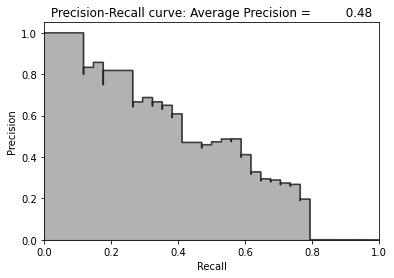

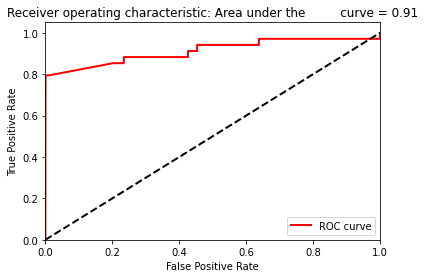

In [41]:
preds, average_Precision = plotResults(y_train, predictions_BasedOn_KFolds.loc[:,'prediction'], True)

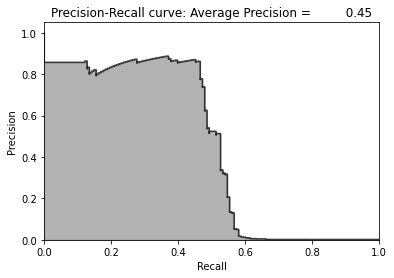

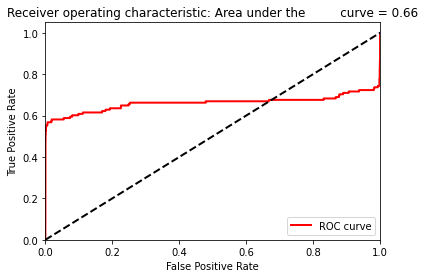

In [42]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration), index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [43]:
preds, precision = precision_Analysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall".format(precision))

Precision at 75% recall 0.0013144922773578706


In [49]:
# Unsupervised Learning
over_sample_multiplier = 100

#Make a copy of original x_train, y_train, X_test and y_test
X_train_o = X_train.copy()
y_train_o = y_train.copy()
X_test_o = X_test.copy()
y_test_o = y_test.copy()

X_train_over_sampled = X_train.copy()
y_train_over_sampled = y_train.copy()
X_train_over_sampled = X_train_over_sampled.append([X_train_over_sampled[y_train==1]]*over_sample_multiplier, ignore_index=False)
y_train_over_sampled = y_train_over_sampled.append([y_train_over_sampled[y_train==1]]*over_sample_multiplier,ignore_index=False)

X_train = X_train_over_sampled.copy()
y_train = y_train_over_sampled.copy()

In [50]:
# Define a model
model_m = Sequential()
model_m.add(Dense(units=40, activation='linear',activity_regularizer=regularizers.l1(10e-5),input_dim=29,name='hidden_layer'))
model_m.add(Dropout(0.02))
model_m.add(Dense(units=29, activation='linear'))

In [51]:
# Compile the model
model_m.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [52]:
# Define parameters
num_epochs = 3
batch_size = 32

# run the model
history = model_m.fit(x=X_train, y=X_train,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.20,
                    verbose=1)

Epoch 1/3
5062/5062 [==============================] - 8s 2ms/step - loss: 70.6217 - accuracy: 0.8781 - val_loss: 3.8353 - val_accuracy: 0.8848
Epoch 2/3
5062/5062 [==============================] - 8s 2ms/step - loss: 10.8421 - accuracy: 0.9125 - val_loss: 4.0354 - val_accuracy: 0.9159
Epoch 3/3
5062/5062 [==============================] - 8s 2ms/step - loss: 7.6891 - accuracy: 0.9245 - val_loss: 3.0963 - val_accuracy: 0.9204


6221/6221 [==============================] - 5s 840us/step


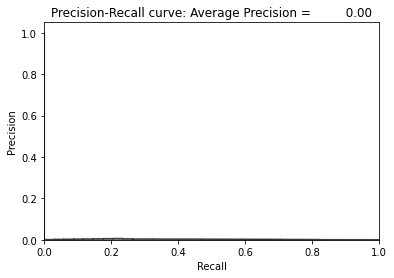

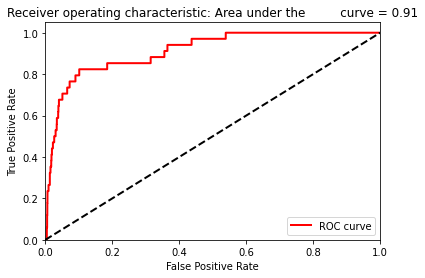

In [54]:
# Make predictions
predictions_Train = model_m.predict(X_train_o, verbose=1)
anomaly_Scores_Train = anomalyScores(X_train_o, predictions_Train)
preds, average_precision = plotResults(y_train_o,anomaly_Scores_Train, True)

2671/2671 [==============================] - 2s 792us/step


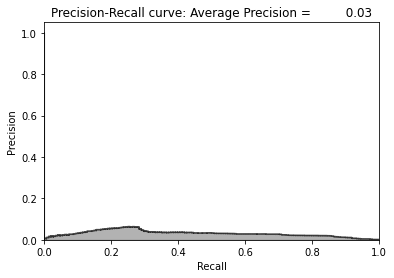

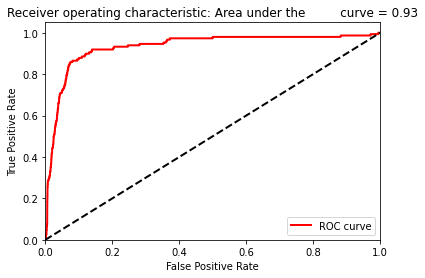

In [55]:
predictions = model_m.predict(X_test, verbose=1)
anomaly_Scores_AE = anomalyScores(X_test, predictions)
preds, average_precision = plotResults(y_test, anomaly_Scores_AE, True)

In [56]:
preds, precision = precision_Analysis(preds, "anomalyScore", 0.75)
print("Precision at 75% recall".format(precision))

Precision at 75% recall


In [57]:
# Semi-supervised
intermediate_layer_model = Model(inputs=model_m.input,outputs=model_m.get_layer('hidden_layer').output)
intermediate_op_train = intermediate_layer_model.predict(X_train_o)
intermediate_op_test = intermediate_layer_model.predict(X_test_o)

In [58]:
intermediate_op_trainDF = pd.DataFrame(data=intermediate_op_train,index=X_train_o.index)
intermediate_op_testDF = pd.DataFrame(data=intermediate_op_test,index=X_test_o.index)

In [26]:
# Define X_train,X_test and Y_train
X_train = X_train_original.merge(intermediate_output_trainDF, \
                                 left_index=True,right_index=True)
X_test = X_test_original.merge(intermediate_output_testDF, \
                               left_index=True,right_index=True)
y_train = y_train_original.copy()

In [61]:
training_Scores = []
cv_Scores = []
predictions_BasedOn_KFolds = pd.DataFrame(data=[],index=y_train.index, columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fld, X_cv_fld = X_train.iloc[train_index,:],X_train.iloc[cv_index,:]
    y_train_fld, y_cv_fld = y_train.iloc[train_index],y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fld, y_train_fld)
    lgb_eval = lgb.Dataset(X_cv_fld, y_cv_fld, reference=lgb_train)
    gbm = lgb.train(params, lgb_train, num_boost_round=5000,valid_sets=lgb_eval, early_stopping_rounds=200)
    
    log_loss_Training = log_loss(y_train_fld,gbm.predict(X_train_fld, num_iteration=gbm.best_iteration))
    training_Scores.append(log_loss_Training)
    
    predictions_BasedOn_KFolds.loc[X_cv_fld.index,'prediction'] = gbm.predict(X_cv_fld, num_iteration=gbm.best_iteration) 
    log_loss_CV = log_loss(y_cv_fld,predictions_BasedOn_KFolds.loc[X_cv_fld.index,'prediction'])
    cv_Scores.append(log_loss_CV)
    
    print('Training Log Loss: '.format(log_loss_Training))
    print('CV Log Loss: '.format(log_loss_CV))
    
logloss_LightGBM_Gradient_Boosting = log_loss(y_train, predictions_BasedOn_KFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: '.format(logloss_LightGBM_Gradient_Boosting))

[1]	valid_0's binary_logloss: 0.0765815
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.0711727
[3]	valid_0's binary_logloss: 0.0672147
[4]	valid_0's binary_logloss: 0.0639765
[5]	valid_0's binary_logloss: 0.0612775
[6]	valid_0's binary_logloss: 0.0589564
[7]	valid_0's binary_logloss: 0.0569165
[8]	valid_0's binary_logloss: 0.0550938
[9]	valid_0's binary_logloss: 0.0534437
[10]	valid_0's binary_logloss: 0.0519371
[11]	valid_0's binary_logloss: 0.0505485
[12]	valid_0's binary_logloss: 0.0492591
[13]	valid_0's binary_logloss: 0.048057
[14]	valid_0's binary_logloss: 0.0469285
[15]	valid_0's binary_logloss: 0.0458665
[16]	valid_0's binary_logloss: 0.0448633
[17]	valid_0's binary_logloss: 0.0439113
[18]	valid_0's binary_logloss: 0.0430062
[19]	valid_0's binary_logloss: 0.0421446
[20]	valid_0's binary_logloss: 0.0413209
[21]	valid_0's binary_logloss: 0.0405322
[22]	valid_0's binary_logloss: 0.0397757
[23]	valid_0's binary_logloss: 0.0390496
[24]

ValueError: ignored

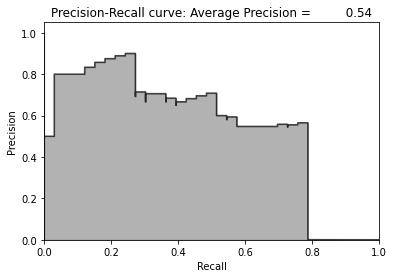

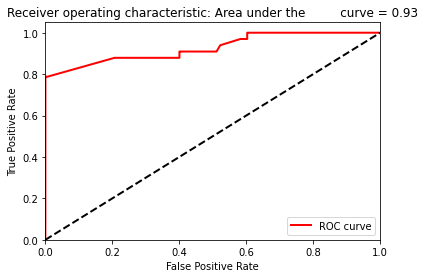

In [28]:
preds, average_precision = plotResults(y_train, predictions_BasedOn_KFolds.loc[:,'prediction'], True)

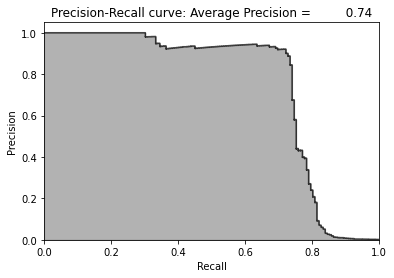

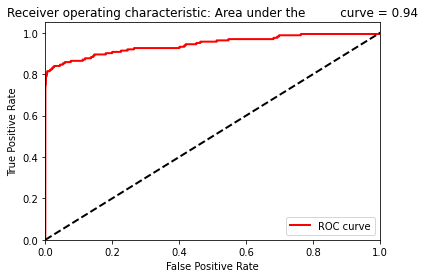

In [29]:
predictions = pd.Series(data=gbm.predict(X_test, num_iteration=gbm.best_iteration),index=X_test.index)
preds, average_precision = plotResults(y_test, predictions, True)

In [62]:
preds, precision = precisionAnalysis(preds, "anomalyScore", 0.75)
print("Precision for Semi-Supervised Learning:{} ".format(precision))

Precision for Semi-Supervised Learning:0.021526042667691717 


In [63]:
# Feature Importance
features_Importance = pd.DataFrame(data=list(gbm.feature_importance()), index=X_train.columns,columns=['featImportance'])
features_Importance = features_Importance/featuresImportance.sum()
features_Importance.sort_values(by='featImportance',ascending=False,inplace=True)
features_Importance

,featImportance
V14,2090.0
V4,1573.0
V25,1391.0
Amount,1247.0
V26,1026.0
V21,935.0
V27,863.0
V15,809.0
V10,752.0
V20,729.0
